### **In this lab, you will be using the Sakila database of movie rentals.**

#### In order to optimize our inventory, we would like to know which films will be rented. We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model.

In [1]:
# setup, import required libraries
import pymysql
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sqlalchemy import create_engine
import getpass  # To get the password without showing the input
password = getpass.getpass()
pd.set_option('display.max_columns', None)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from turtle import title

pd.set_option('display.max_columns', None)

***Instructions*** 

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).

2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

In [2]:
# getting the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''
SELECT f.title,
	f.rental_rate,
    f.length,
    f.rating,
    fc.category_id,
    f.replacement_cost, 
CASE
WHEN MONTH(r.rental_date) = 5 AND YEAR(r.rental_date) = 2005 THEN 1
ELSE 0
END AS rented_in_may
FROM film f
LEFT JOIN inventory i
USING (film_id)
LEFT JOIN rental r
USING(inventory_id)
LEFT JOIN film_category fc
USING(film_id);
'''

data = pd.read_sql_query(query, engine)
display(data.shape)
data.head(5)

(16087, 7)

,title,rental_rate,length,rating,category_id,replacement_cost,rented_in_may
0,ACADEMY DINOSAUR,0.99,86,PG,6,20.99,0
1,ACADEMY DINOSAUR,0.99,86,PG,6,20.99,0
2,ACADEMY DINOSAUR,0.99,86,PG,6,20.99,0
3,ACADEMY DINOSAUR,0.99,86,PG,6,20.99,1
4,ACADEMY DINOSAUR,0.99,86,PG,6,20.99,0


In [3]:
# check unique titles
len(data['title'].unique())

1000

In [4]:
# remmoce duplicate titles, keep rented_in_may 
data = data.groupby(['title','rental_rate', 'length', 'rating', 'category_id','replacement_cost'])\
    .agg({'rented_in_may': lambda x: any(x)}).reset_index()
data

,title,rental_rate,length,rating,category_id,replacement_cost,rented_in_may
0,ACADEMY DINOSAUR,0.99,86,PG,6,20.99,True
1,ACE GOLDFINGER,4.99,48,G,11,12.99,False
2,ADAPTATION HOLES,2.99,50,NC-17,6,18.99,True
3,AFFAIR PREJUDICE,2.99,117,G,11,26.99,True
4,AFRICAN EGG,2.99,130,G,8,22.99,True
...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,0.99,183,G,6,9.99,False
996,YOUTH KICK,0.99,179,NC-17,12,14.99,False
997,ZHIVAGO CORE,0.99,105,NC-17,11,10.99,True
998,ZOOLANDER FICTION,2.99,101,R,3,28.99,True


3. Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.

In [5]:
data

,title,rental_rate,length,rating,category_id,replacement_cost,rented_in_may
0,ACADEMY DINOSAUR,0.99,86,PG,6,20.99,True
1,ACE GOLDFINGER,4.99,48,G,11,12.99,False
2,ADAPTATION HOLES,2.99,50,NC-17,6,18.99,True
3,AFFAIR PREJUDICE,2.99,117,G,11,26.99,True
4,AFRICAN EGG,2.99,130,G,8,22.99,True
...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,0.99,183,G,6,9.99,False
996,YOUTH KICK,0.99,179,NC-17,12,14.99,False
997,ZHIVAGO CORE,0.99,105,NC-17,11,10.99,True
998,ZOOLANDER FICTION,2.99,101,R,3,28.99,True


4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [6]:
# check for NaN-values
data.isna().sum()


title               0
rental_rate         0
length              0
rating              0
category_id         0
replacement_cost    0
rented_in_may       0
dtype: int64

In [7]:
data.dtypes

title                object
rental_rate         float64
length                int64
rating               object
category_id           int64
replacement_cost    float64
rented_in_may          bool
dtype: object

In [8]:
data['category_id'] = data['category_id'].astype('object') 
data.drop('title', axis=1, inplace=True)
data.dtypes

rental_rate         float64
length                int64
rating               object
category_id          object
replacement_cost    float64
rented_in_may          bool
dtype: object

In [9]:
# train-test-split
y = data['rented_in_may']
X = data.drop(['rented_in_may'], axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# split numericals and categoricals
X_train_num = X_train.select_dtypes(include = np.number)
X_test_num  = X_test.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)
X_test_cat  = X_test.select_dtypes(include = object)

In [12]:
X_train_num

,rental_rate,length,replacement_cost
29,2.99,82,27.99
535,2.99,65,18.99
695,0.99,114,20.99
557,2.99,71,18.99
836,2.99,85,19.99
...,...,...,...
106,2.99,63,13.99
270,4.99,148,12.99
860,4.99,111,12.99
435,0.99,122,14.99


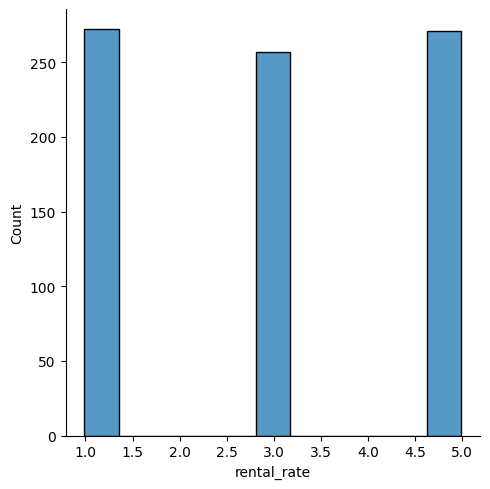

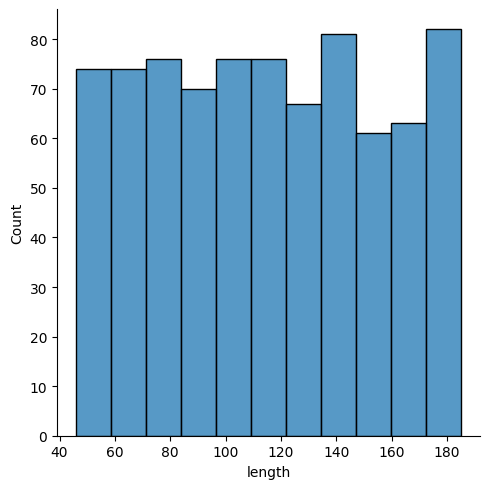

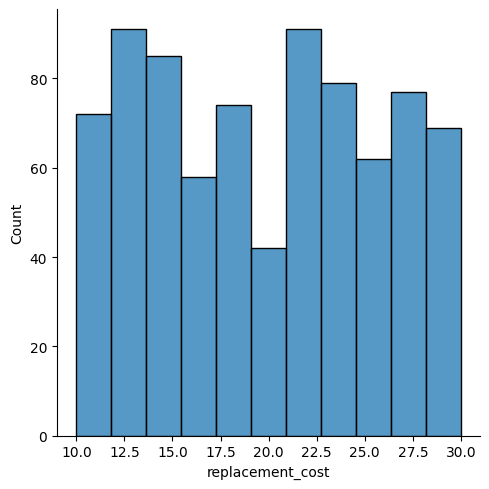

In [13]:

sns.displot(X_train_num['rental_rate'])
plt.show()

sns.displot(X_train_num['length'])
plt.show()

sns.displot(X_train_num['replacement_cost'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

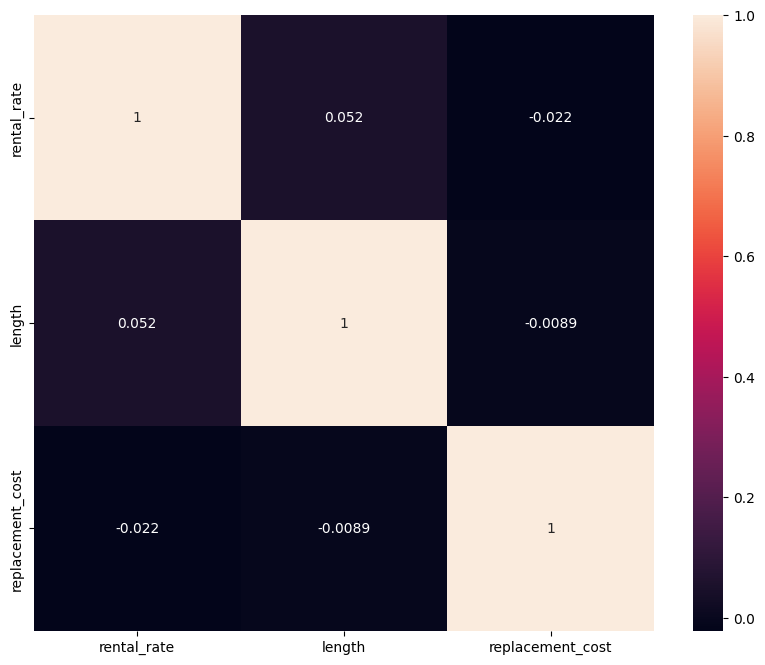

In [14]:
corr_matrix=X_train_num.select_dtypes(include=[np.number]).corr()  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show

In [15]:
X_train_num.describe().T

,count,mean,std,min,25%,50%,75%,max
rental_rate,800.0,2.98750,1.648755,0.99,0.99,2.99,4.99,4.99
length,800.0,114.55375,40.613377,46.00,79.00,113.00,148.25,185.00
replacement_cost,800.0,19.80125,5.988777,9.99,13.99,19.99,24.99,29.99


In [16]:
# Normalizing data
transformer = MinMaxScaler().fit(X_train_num) 
X_train_scaled_arr = transformer.transform(X_train_num)
X_train_scaled = pd.DataFrame(X_train_scaled_arr, columns=X_train_num.columns)
display(X_train_scaled.head())
X_train_scaled.describe().T

,rental_rate,length,replacement_cost
0,0.5,0.258993,0.90
1,0.5,0.136691,0.45
2,0.0,0.489209,0.55
3,0.5,0.179856,0.45
4,0.5,0.280576,0.50


,count,mean,std,min,25%,50%,75%,max
rental_rate,800.0,0.499375,0.412189,0.0,0.00000,0.500000,1.000000,1.0
length,800.0,0.493192,0.292183,0.0,0.23741,0.482014,0.735612,1.0
replacement_cost,800.0,0.490562,0.299439,0.0,0.20000,0.500000,0.750000,1.0


In [17]:
X_train_cat

,rating,category_id
29,R,11
535,PG,4
695,NC-17,2
557,PG-13,13
836,PG,5
...,...,...
106,G,7
270,G,1
860,R,10
435,NC-17,13


In [18]:
encoder = OneHotEncoder(drop='first').fit(X_train_cat)
encoded_cat = encoder.transform(X_train_cat).toarray()
cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)
onehot_encoded = pd.DataFrame(encoded_cat, columns=cols)
onehot_encoded.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_id_2,category_id_3,category_id_4,category_id_5,category_id_6,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
X_train_treated = pd.concat([X_train_scaled, onehot_encoded], axis=1)
X_train_treated

,rental_rate,length,replacement_cost,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_id_2,category_id_3,category_id_4,category_id_5,category_id_6,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
0,0.5,0.258993,0.90,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.5,0.136691,0.45,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.489209,0.55,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.5,0.179856,0.45,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.5,0.280576,0.50,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.5,0.122302,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,1.0,0.733813,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,1.0,0.467626,0.15,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
798,0.0,0.546763,0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

In [20]:
classification = LogisticRegression()
classification.fit(X_train_treated, y_train)

LogisticRegression()

6. Evaluate the results.

In [21]:
# treat the test data
X_test_scaled_arr = transformer.transform(X_test_num)
X_test_scaled = pd.DataFrame(X_test_scaled_arr, columns=X_test_num.columns)
X_test_scaled.head(6)

,rental_rate,length,replacement_cost
0,0.5,0.654676,0.00
1,0.0,0.949640,0.90
2,0.0,0.251799,0.95
3,1.0,0.798561,0.40
4,1.0,0.402878,0.80
5,0.5,0.028777,0.40


In [22]:
encoded_test_cat = encoder.transform(X_test_cat).toarray()
onehot_encoded_test = pd.DataFrame(encoded_test_cat, columns=cols)
onehot_encoded_test.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_id_2,category_id_3,category_id_4,category_id_5,category_id_6,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
X_test_treated = pd.concat([X_test_scaled, onehot_encoded_test], axis=1)
X_test_treated

,rental_rate,length,replacement_cost,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_id_2,category_id_3,category_id_4,category_id_5,category_id_6,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
0,0.5,0.654676,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.949640,0.90,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.251799,0.95,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.798561,0.40,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.402878,0.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.0,0.093525,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,0.5,0.575540,0.35,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
197,0.5,0.381295,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,1.0,0.949640,0.10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
## get predictions
predictions = classification.predict(X_test_treated)
predictions

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [25]:
classification.score(X_test_treated, y_test)

0.675

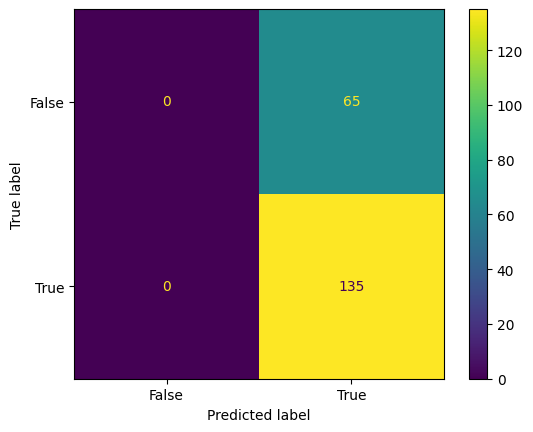

In [26]:
cm = confusion_matrix(y_test, predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classification.classes_)
cm_display.plot()
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

### **AFTER LESSON ON IMBALANCED DATA**

In [27]:
y.value_counts()

rented_in_may
True     686
False    314
Name: count, dtype: int64

In [28]:
sm = SMOTE(random_state=100, k_neighbors=3)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_treated,y_train)
X_train_SMOTE.shape

(1102, 22)

In [29]:
LR_smote = LogisticRegression(random_state=0, solver='lbfgs')
LR_smote.fit(X_train_SMOTE, y_train_SMOTE)
pred_smote = LR_smote.predict(X_test_treated)

In [30]:
print("accuray: ",accuracy_score(y_test,pred_smote))
print("precision: ",precision_score(y_test,pred_smote))
print("recall: ",recall_score(y_test,pred_smote))
print("f1: ",f1_score(y_test,pred_smote))

accuray:  0.615
precision:  0.7416666666666667
recall:  0.6592592592592592
f1:  0.6980392156862745


array([[34, 31],
       [46, 89]])

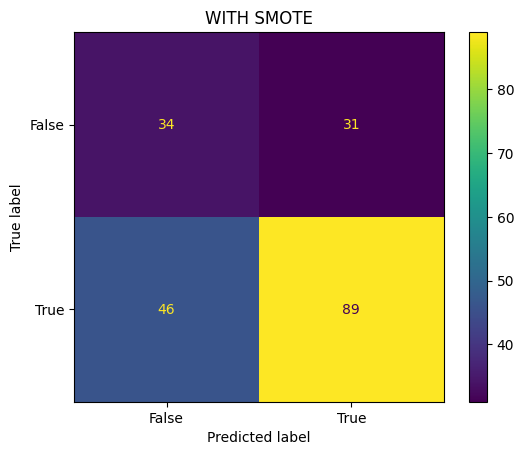

In [31]:
cm = confusion_matrix(y_test,pred_smote)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR_smote.classes_)
cm_display.plot()
plt.title('WITH SMOTE')
confusion_matrix(y_test,pred_smote)

In [32]:
y_train_SMOTE.value_counts()

rented_in_may
True     551
False    551
Name: count, dtype: int64

> It is still a bad model --> garbage in, garbage out ;-) 
> having balanced it, we at least get some correct predicitons for false, but also false negatives... 